In [112]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

from src.nf_maf import init_model, show, load_and_preprocess_mnist, MNISTSampler, inverse_logit
import pickle

MCMCKernel = RandomWalkMH # RandomWalkBarker 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
layers = 10
load_dir = "res/tmp_10_256"
checkpoint, maf, batched_train_data = init_model(
    category=[0, 1], load=True, layers=layers, logit_space=False,
    load_dir=f"{load_dir}/ckpt")

num in classes in train: [(0, 4932), (1, 5678)]
num in classes in val: [(0, 991), (1, 1064)]
num in classes in test: [(0, 980), (1, 1135)]


2022-04-29 15:11:51.233948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Successfully initialized!
Successfully loaded trained model res/tmp_10_256/ckpt !


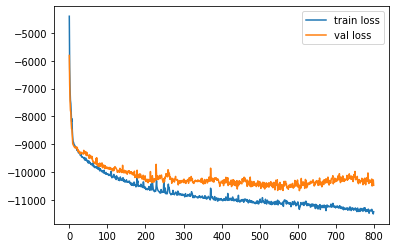

In [115]:
loss_hist = pickle.load(open(f"{load_dir}/loss_hist.pkl", "rb"))
global_step = loss_hist["global_step"]
train_losses = loss_hist["train_losses"]
val_losses = loss_hist["val_losses"]

# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()

In [116]:
xx = maf.sample(20)

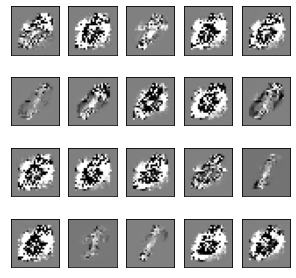

In [117]:
show(xx)

# KSD test

In [101]:
# # can only run once!
# log_prob_old = maf.log_prob

# def maf_log_prob(img):
#     img = tf.reshape(img, (-1, 28, 28))
#     return log_prob_old(img)

# maf.log_prob = maf_log_prob

In [119]:
tf.random.set_seed(1)

n = 100

num in classes in train: [(0, 4932), (1, 5678)]
num in classes in val: [(0, 991), (1, 1064)]
num in classes in test: [(0, 980), (1, 1135)]


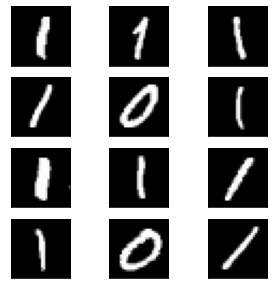

In [120]:
# # take digits 1 only
# sample_batch, _, _, _ = load_and_preprocess_mnist(logit_space=True, batch_size=128, classes=[1])
# train_data_tensor = tf.concat(list(sample_batch), axis=0)

# ind = np.random.randint(0, train_data_tensor.shape[0], size=n).tolist()
# sample_off = np.take(train_data_tensor, ind, axis=0)
# sample_off = tf.reshape(sample_off, (-1, 28*28))

# show(np.take(train_data_tensor, ind, axis=0)[:12])

mnist_sampler = MNISTSampler(category=[0, 1], logit_space=True)
sample_off = mnist_sampler.sample(n)

# #! delete
# sample_off = inverse_logit(sample_off) / 256.

show(np.reshape(sample_off[:12], (-1, 28, 28)))

In [121]:
sample_on = maf.sample(n)

In [122]:
print("max:", tf.reduce_max(sample_on), tf.reduce_max(sample_off))
print("min:", tf.reduce_min(sample_on), tf.reduce_min(sample_off))

# print("max:", tf.reduce_max(inverse_logit(sample_on)), tf.reduce_max(inverse_logit(sample_off)))
# print("min:", tf.reduce_min(inverse_logit(sample_on)), tf.reduce_min(inverse_logit(sample_off)))

max: tf.Tensor(17812.61, shape=(), dtype=float32) tf.Tensor(5.528599, shape=(), dtype=float32)
min: tf.Tensor(-19423.754, shape=(), dtype=float32) tf.Tensor(-9.903438, shape=(), dtype=float32)


In [123]:
sample_off[0, 295:298]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([4.4305706, 3.9135094, 3.9135094], dtype=float32)>

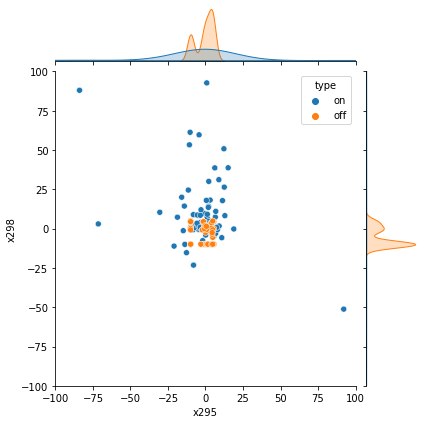

In [132]:
dim_list = [295, 298]
on_df = pd.DataFrame({f"x{i}": sample_on.numpy()[:, i] for i in dim_list})
on_df["type"] = "on"
off_df = pd.DataFrame({f"x{i}": sample_off.numpy()[:, i] for i in dim_list})
off_df["type"] = "off"

plot_df = pd.concat([on_df, off_df], ignore_index=True)

# plot_df = plot_df.loc[plot_df.type == "on"]
# plot_df = plot_df.loc[plot_df.type == "off"]

axislim = 100
_ = sns.jointplot(data=plot_df, x=f"x{dim_list[0]}", y=f"x{dim_list[1]}", hue="type",
                 xlim=(-axislim, axislim),
                 ylim=(-axislim, axislim),
                 )


In [109]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=maf, kernel=kernel)

In [28]:
# initialise bootstrap
bootstrap_nopert = Bootstrap(ksd, n)
multinom_samples_notrain = bootstrap_nopert.multinom.sample((nrep, num_boot)) # nrep x num_boot x n

2022-04-29 11:26:14.516529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
## KSD
multinom_one_sample = multinom_samples_notrain[0, :] # nrep x num_boost x n

# compute p-value
rej_on, pval_on = bootstrap_nopert.test_once(
    alpha=alpha, num_boot=num_boot,X=sample_on, multinom_samples=multinom_one_sample)

rej_off, pval_off = bootstrap_nopert.test_once(
    alpha=alpha, num_boot=num_boot,X=sample_off, multinom_samples=multinom_one_sample)

In [ ]:
print("on p-value:", pval_on, "off p-value:", pval_off)

In [36]:
print("on p-value:", pval_on, "off p-value:", pval_off)

on p-value: 0.04369538077403246 off p-value: 0.982521847690387


In [81]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [82]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [83]:
std = 0.9

In [92]:
T = 100
log_prob_fn = maf.log_prob
ntrain = n # n//2
sample_off_train = sample_on[:ntrain]

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=sample_off_train, ind_pair_list=ind_pair_list, **proposal_dict)

In [93]:
## pKSD
multinom_one_sample = multinom_samples_notrain[0, :] # nrep x num_boost x n

# perturbed sample
x_t = mh.x[-1, :, :].numpy()

# compute p-value
pert_rej_on, pert_pval = bootstrap_nopert.test_once(
    alpha=alpha, num_boot=num_boot,X=x_t, multinom_samples=multinom_one_sample)

In [94]:
print("p-value before:", pval_on, "p-value after:", pert_pval)

p-value before: 0.2808988764044944 p-value after: 0.2808988764044944


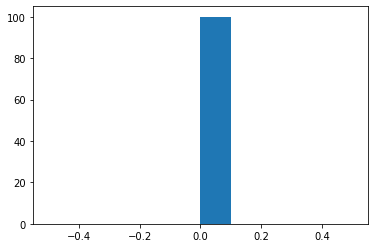

In [97]:
if_accepted = (np.sum(mh.if_accept.numpy(), axis=0) > 0.).astype(np.float32)
_ = plt.hist(if_accepted)

In [96]:
xx

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

# Load results

In [14]:
# dir = "res/nf/barkerNone_steps100_n50_seed2022"
dir = "res/nf/barkerNone_steps100_n100_seed2022"
res = pd.read_csv(f"{dir}.csv")

In [17]:
res

,method,rej,seed
0,KSD,0,0
1,pKSD mc,0,0
2,KSDAGG,0,0
3,KSD,0,1
4,pKSD mc,0,1
...,...,...,...
145,pKSD mc,0,48
146,KSDAGG,0,48
147,KSD,0,49
148,pKSD mc,0,49
